## San Diego COVID-19 History and Projections

For the past few weeks, the San Diego Regional Data Library has been scraping the offical COVID statistics from the County of San Diego. The data package is in the [Library's data repository](https://data.sandiegodata.org/dataset/sandiegodata-org-covid19-1-2-0/). Along with other data in the Library's collection, we now have neough observations to produce some estimates of the future growth of cases in the County 


In [1]:
import sys
# Install required packages
!{sys.executable} -mpip -q install matplotlib seaborn statsmodels pandas publicdata metapack

%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import metapack as mp
import rowgenerators as rg
import publicdata as pub
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

from sklearn import  linear_model
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.stats import weibull_min, lognorm, logistic, norm
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.metrics import r2_score


In [2]:
import metapack as mp
pkg = mp.open_package('http://library.metatab.org/sandiegocounty.gov-covid19.csv')
pkg

# COVID 19 Statistics San Diego County
`sandiegocounty.gov-covid19-1.1.15` Last Update: 2020-05-24T15:35:24

_Official COVID-19 statistics for San Diego County._


## Documentation Links

* [Homepage](http://sdgis-sandag.opendata.arcgis.com/datasets/covid-19-statistics-san-diego-county) One of the pages linking to COVID-19 data posted on arcgis.com

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)
* **Origin** County of San Diego, Health and Human Services Agency, Public Health Services, Epidemiology and Immunization Services Branch

## Resources

* ** [covid_stats](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.15/data/covid_stats.csv)**. COVID-19 cases in San Diego County, by sex and age
* ** [covid_jurisdiction](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.15/data/covid_jurisdiction.csv)**. COVID-19 cases by San Diego jurisdiction
* ** [covid_jurisdiction_geo](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.15/data/covid_jurisdiction_geo.csv)**. COVID-19 cases by San Diego jurisdiction, geographic
* ** [covid_zip](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.15/data/covid_zip.csv)**. COVID-19 cases by zip code
* ** [covid_zip_geo](http://library.metatab.org/sandiegocounty.gov-covid19-1.1.15/data/covid_zip_geo.csv)**. COVID-19 cases by zip code, geographic

In [3]:
# Create Dataframes
covid_stats_df = pkg.resource('covid_stats').dataframe()
covid_jurisdiction_df = pkg.resource('covid_jurisdiction').dataframe()
covid_jurisdiction_geo_gdf = pkg.resource('covid_jurisdiction_geo').geoframe()
covid_zip_df = pkg.resource('covid_zip').dataframe()
covid_zip_geo_gdf = pkg.resource('covid_zip_geo').geoframe()

covid_stats_df.deaths

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
      ...  
72    222.0
73    230.0
74    241.0
75    242.0
76    249.0
Name: deaths, Length: 77, dtype: float64

In [4]:
df = covid_stats_df[['date','tests','positives','hospitalized','icu','deaths']].sort_values('date')
df['date'] = pd.to_datetime(df.date)

df.columns = ['date', 'tests', 'cases', 'hosp','icu', 'deaths']
df['date'] = pd.to_datetime(df.date)
start_date = df.iloc[0].date
start_cases = df.iloc[0].cases
df['day'] = (df.date - start_date).dt.days

df['new_cases'] = df.cases.diff()
df['cases_rate'] = df.cases.diff()/ df.cases.shift(1)
df['cases_smooth'] = lowess(df.cases, df.day)[:,1]
df['cases_smooth_rate'] = df.cases_smooth.diff()/df.cases_smooth.shift(1)

df['new_hosp'] = df.hosp.diff()
df['hosp_rate'] = df.hosp.diff()/ df.hosp.shift(1)
df['hosp_smooth'] = lowess(df.hosp.fillna(0), df.day)[:,1]
df['hosp_smooth_rate'] = df.hosp.diff()/df.hosp_smooth.shift(1)

df['new_deaths'] = df.deaths.diff()
df['deaths_rate'] = df.deaths.diff()/ df.deaths.shift(1)
df['deaths_smooth'] = lowess(df.deaths.fillna(0), df.day)[:,1]
df['deaths_smooth_rate'] = df.deaths_smooth.diff()/df.deaths_smooth.shift(1)

#df['double_days'] = np.log(2)/np.log(1+df.cases_smooth_rate)


df.tail()

,date,tests,cases,hosp,icu,deaths,day,new_cases,cases_rate,cases_smooth,cases_smooth_rate,new_hosp,hosp_rate,hosp_smooth,hosp_smooth_rate,new_deaths,deaths_rate,deaths_smooth,deaths_smooth_rate
72,2020-05-18 08:00:00,111035.0,6026,1136.0,346.0,222.0,72,80.0,0.013454,6014.764260,0.021470,21.0,0.018834,1139.807906,0.018745,11.0,0.052133,223.156088,0.022763
73,2020-05-19 08:00:00,115837.0,6140,1155.0,351.0,230.0,73,114.0,0.018918,6141.356005,0.021047,19.0,0.016725,1159.336455,0.016669,8.0,0.036036,228.127498,0.022278
74,2020-05-20 08:00:00,120559.0,6315,1183.0,354.0,241.0,74,175.0,0.028502,6268.105321,0.020639,28.0,0.024242,1178.868225,0.024152,11.0,0.047826,233.103920,0.021814
75,2020-05-21 08:00:00,124615.0,6434,1209.0,361.0,242.0,75,119.0,0.018844,6395.001544,0.020245,26.0,0.021978,1198.403776,0.022055,1.0,0.004149,238.085527,0.021371
76,2020-05-22 08:00:00,128410.0,6559,1224.0,369.0,249.0,76,125.0,0.019428,6522.033837,0.019864,15.0,0.012407,1217.943513,0.012517,7.0,0.028926,243.072322,0.020945


In [5]:
df.set_index('date').cases_rate.tail(15)


date
2020-05-08 08:00:00    0.024453
2020-05-09 08:00:00    0.031407
2020-05-10 08:00:00    0.028218
2020-05-11 08:00:00    0.018954
2020-05-12 08:00:00    0.022670
2020-05-13 08:00:00    0.021410
2020-05-14 08:00:00    0.024485
2020-05-15 08:00:00    0.025167
2020-05-16 08:00:00    0.030731
2020-05-17 08:00:00    0.018849
2020-05-18 08:00:00    0.013454
2020-05-19 08:00:00    0.018918
2020-05-20 08:00:00    0.028502
2020-05-21 08:00:00    0.018844
2020-05-22 08:00:00    0.019428
Name: cases_rate, dtype: float64

In [6]:
def func_norm(x, loc, scale, a):
    return a*norm.pdf(x,loc, scale)
func_norm.popt =  (22, 10, 3659)

def func_logpdf(x, loc, scale, a):
    return a*logistic.pdf(x,loc, scale)
func_logpdf.popt =  (22, 10, 3659)

def func_logistic(x, loc, scale, a): # popt = (14,4, 800)
    return a*logistic.cdf(x, loc, scale)
func_logistic.popt =  (14,4, 800)


def func_erf(x, loc, scale, a, b):
    return a*erf( (x-loc) / scale ) + b
func_erf.popt = (50,20,3000,3000)

def func_gomp(x, a, b, c):
    return a * np.exp(-b * np.exp(-c * x))
func_gomp.popt = (1000,10,.1)




[1.28252454e+04 5.31534430e+00 2.70883406e-02]


/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


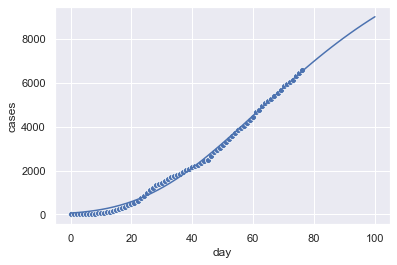

In [7]:
t = df.copy() 


popt, pcov = curve_fit(func_gomp, t.day, t.cases, absolute_sigma = True)
print(popt)

sns.scatterplot(x=t.day, y=t.cases)

x=np.linspace(0,100)


sns.lineplot(x=x, y=func_gomp(x, *popt))

    

/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


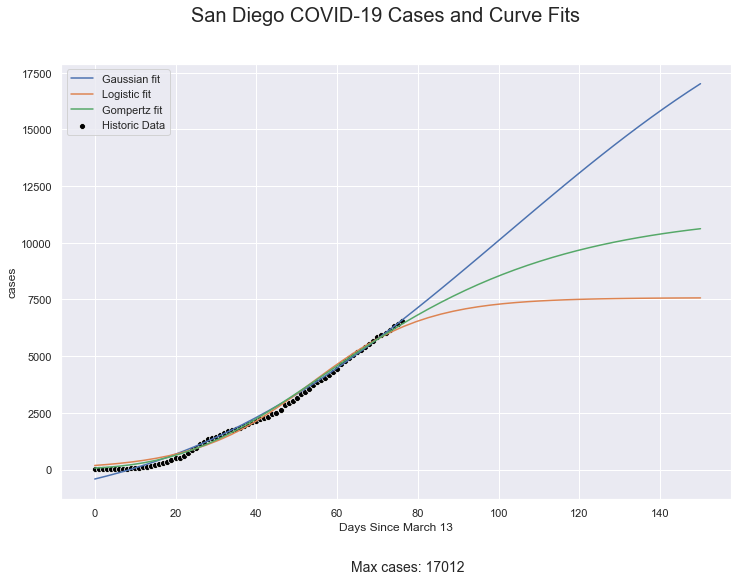

In [21]:



def ln_fit(df, fig, ax, col_name, use_smooth=True, pred_days = 150, text=True, fit_func = func_erf, label='', normalize=False):


    fit_col = col_name+'_smooth' if use_smooth else col_name
    
    t = df.dropna(subset=['day',fit_col])
    
    popt, pcov = curve_fit(fit_func, t.day, t[fit_col], p0=fit_func.popt, absolute_sigma = True)
   
    x=np.linspace(0,pred_days)
    proj = fit_func(x, *popt)
    
    sns.lineplot(x=x, y=proj/(proj.max() if normalize else 1), ax=ax, label=label)
    
    perr = np.sqrt(np.diag(pcov))
    
    max_cases = np.max(proj)
    
    if text: 
        plt.gcf().text(.46,-0,f"Max {col_name}: {max_cases:5.0f}", fontsize=14) 
    
    return popt, perr, x, proj

fig, ax = plt.subplots(figsize=(12,8))

t = df.copy()
#t.cases = lowess(df.cases, df.day, is_sorted=True, frac=0.4, it=0)[:,1]

popt, perr, x, cases_d_e = ln_fit(t[:], fig, ax, 'cases', fit_func = func_erf, label="Gaussian fit")
##print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_e[:len(t.cases)])}")

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_logistic, label='Logistic fit')
#print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_l[:len(t.cases)])}")

popt, perr, x, cases_d_l = ln_fit(t[:], fig, ax, 'cases', text=False, fit_func = func_gomp, label='Gompertz fit')
#print(f"Mean={round(popt[0])}, R^2={r2_score(t.cases, cases_d_l[:len(t.cases)])}")
    
sns.scatterplot(x='day', y='cases', data=t, ax=ax, color='black', label='Historic Data')

    
    
    
ax.set_xlabel("Days Since March 13")   
fig.suptitle("San Diego COVID-19 Cases and Curve Fits", fontsize=20);


**On the downslope**. It looks like San Diego has hit its peak in new coronavirus cases. This plot shows the daily increase or decrease in the number of confirmed coronavirus cases for San Diego County. The full plot should look a lot like a Normal distribution ( aka bell curve ) so you can see that we'd just hit the peak a few days ago. From here out, we should see, each day, a smaller number of new cases than the day before.  

Death, how ever, have not hit the peak, because deaths lag cases by about 10 days. 


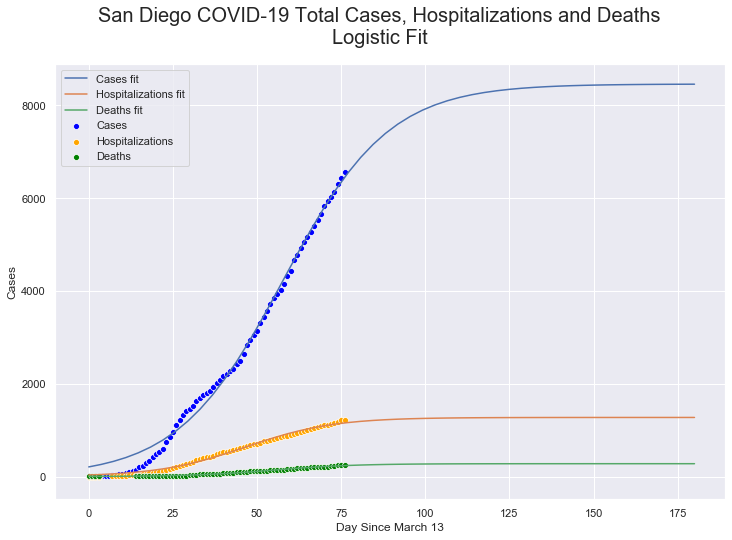

In [9]:


def tc_plot(ax, fit_func):

    t = df.dropna(subset=['day','cases','hosp', 'deaths']).copy()

    x = np.linspace(0,180)

    popt, pcov = curve_fit(fit_func, t.day, t.cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Cases fit')
    sns.scatterplot(df.day, df.cases, ax=ax, color='blue', label='Cases')    
    #print(f"C Mean={round(popt[0])}, R^2={r2_score(df.cases, fitted[:len(df.cases)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.hosp,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Hospitalizations fit')
    sns.scatterplot(df.day, df.hosp,  ax=ax, color='orange', label='Hospitalizations')
    #print(f"H Mean={round(popt[0])}, R^2={r2_score(df.hosp.fillna(0), fitted[:len(df.hosp)])}")

    popt, pcov = curve_fit(fit_func, t.day, t.deaths,popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    sns.lineplot(x, fitted, label='Deaths fit')
    #sns.lineplot(x=df.day, y=df.deaths_smooth, ax=ax, label='Deaths')   
    sns.scatterplot(t.day, t.deaths+1, ax=ax, color='green', label='Deaths')
    #print(f"D Mean={round(popt[0])}, R^2={r2_score(df.deaths.fillna(0), fitted[:len(df.deaths)])}")

    
fig, ax = plt.subplots(figsize=(12,8))   
tc_plot(ax, func_logistic)
ax.set_ylabel('Cases')
ax.set_xlabel('Day Since March 13')
fig.suptitle("San Diego COVID-19 Total Cases, Hospitalizations and Deaths\nLogistic Fit", fontsize=20);

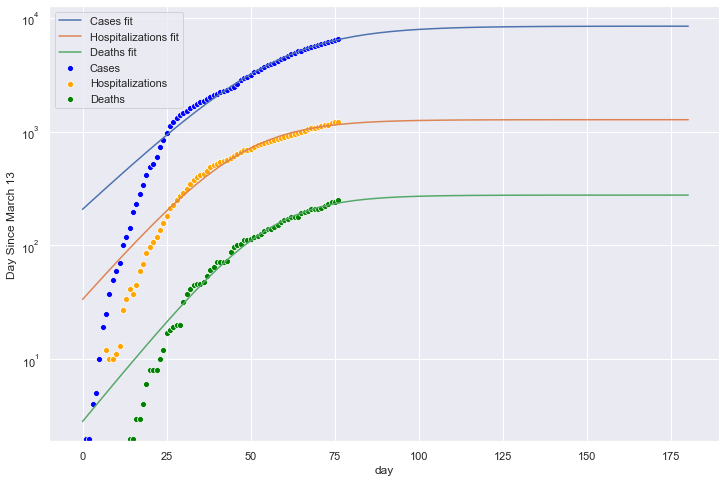

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

tc_plot(ax, func_logistic)

plt.yscale('log')

ax.set_ylabel('Cases')
ax.set_ylabel('Day Since March 13');

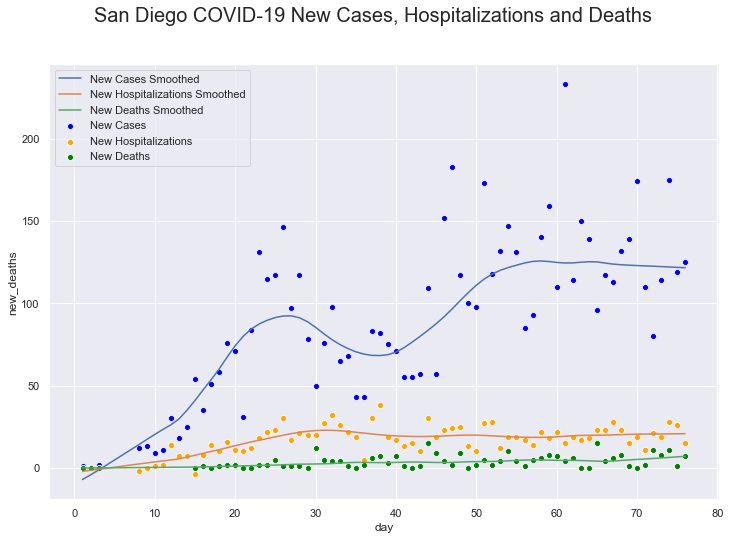

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);


smoothing = 0.3

fit_func = func_logpdf 

t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

t.new_hosp = t.new_hosp
t.new_cases = t.new_cases
t.new_deaths = t.new_deaths

x = np.linspace(0,60)

sns.scatterplot(df.day, t.new_cases, ax=ax, color='blue', label='New Cases')
smoothed = lowess(t.new_cases,  t.day,smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Cases Smoothed')

sns.scatterplot(df.day, t.new_hosp, ax=ax, color='orange', label='New Hospitalizations')
smoothed = lowess(t.new_hosp,  t.day, smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Hospitalizations Smoothed')


sns.scatterplot(t.day, t.new_deaths, ax=ax, color='green', label='New Deaths')
smoothed = lowess(t.new_deaths,  t.day, smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Deaths Smoothed')


''

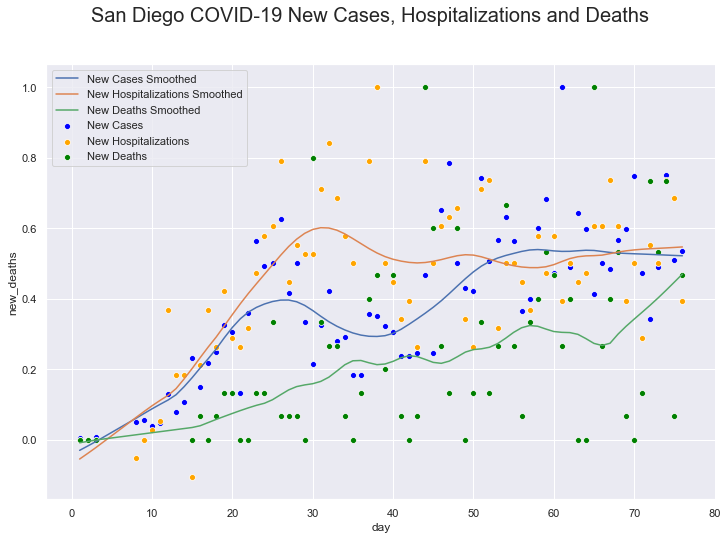

In [12]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);


smoothing = 0.3

fit_func = func_logpdf 

t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

t.new_hosp = t.new_hosp/np.max(t.new_hosp)
t.new_cases = t.new_cases/np.max(t.new_cases)
t.new_deaths = t.new_deaths/np.max(t.new_deaths)

x = np.linspace(0,60)

sns.scatterplot(df.day, t.new_cases, ax=ax, color='blue', label='New Cases')
smoothed = lowess(t.new_cases,  t.day,smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Cases Smoothed')

sns.scatterplot(df.day, t.new_hosp, ax=ax, color='orange', label='New Hospitalizations')
smoothed = lowess(t.new_hosp,  t.day, smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Hospitalizations Smoothed')


sns.scatterplot(t.day, t.new_deaths, ax=ax, color='green', label='New Deaths')
smoothed = lowess(t.new_deaths,  t.day, smoothing)
sns.lineplot(smoothed[:,0], smoothed[:,1], label='New Deaths Smoothed')
;

In [13]:
t = pd.Timestamp('2020-03-13', freq='D') 
t + t.freq*42   

Timestamp('2020-04-24 00:00:00', freq='D')

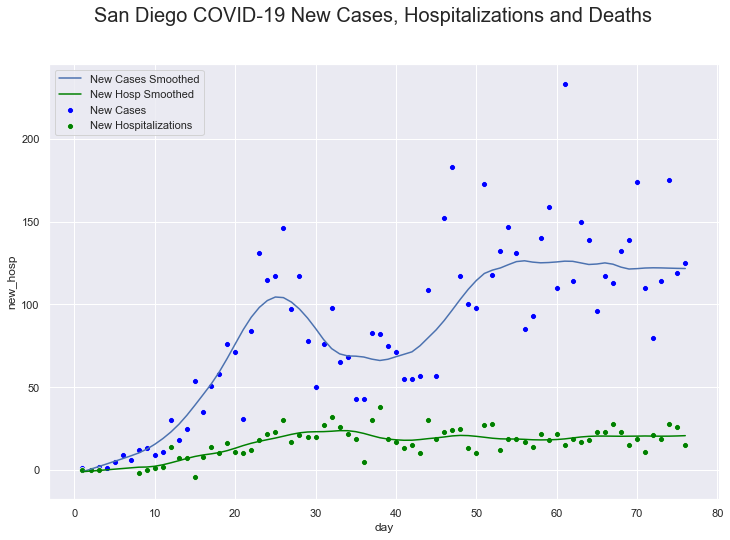

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths", fontsize=20);

def nc_plot(df, pct_cases=None, cases_only=False):
    # Fit a normal PDF

    fit_func = func_logpdf or fit_func

    if pct_cases:
        df = df.iloc[:int(pct_cases*len(df))]
    
    t = df.dropna(subset=['day','new_cases','new_hosp']).copy()


    x = np.linspace(0,60)

    sns.scatterplot(df.day, df.new_cases, ax=ax, color='blue', label='New Cases')

    tdl = lowess(df.new_cases,  df.day, 0.2)
    sns.lineplot(tdl[:,0], tdl[:,1], label='New Cases Smoothed')

    sns.scatterplot(df.day, df.new_hosp,  ax=ax, color='green', label='New Hospitalizations')
    
    tdl = lowess(df.new_hosp,  df.day, 0.2)
    sns.lineplot(tdl[:,0], tdl[:,1], label='New Hosp Smoothed', color='green')

      
        
nc_plot(df,1, cases_only=False)


/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4221: RuntimeWarning: overflow encountered in exp
  return -x - 2. * sc.log1p(np.exp(-x))


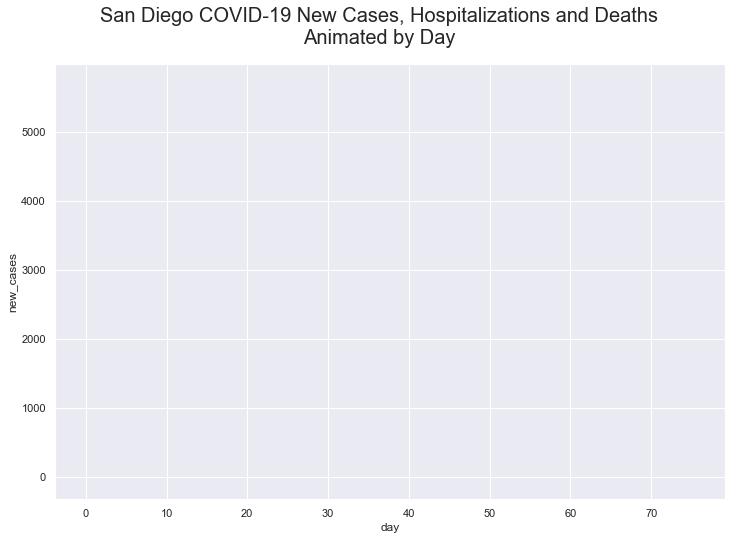

In [15]:

def ani_nc_plot(ax, df, i, last):
    # Fit a normal PDF

    fit_func = func_logpdf or fit_func

    df = df.iloc[:i]
    
    t = df.dropna(subset=['day','new_cases','new_hosp']).copy()

    x = np.linspace(0,60)

    p1 = sns.scatterplot(df.day, df.new_cases, ax=ax, color='blue')

    tdl = lowess(df.new_cases,  df.day, 0.4)[:,1]
    p2 = sns.lineplot(df.day[:-1], tdl, ax=ax, color='blue')

    popt, pcov = curve_fit(fit_func, t.day, t.new_cases, p0=fit_func.popt, absolute_sigma = True)
    fitted = fit_func(x, *popt)
    
    try:
        d = abs(np.max(fitted) - np.max(last))
    except:
        d = 0
    
    # When the distribution is absurd, use the previous one
    if d > 30:
        dist = last
    else:
        dist = fitted
   
    p3 = sns.lineplot(x, dist, ax=ax, color='orange')

    #ax.legend(p1,['New Cases'])
    
    return fittted

from celluloid import Camera
fig, ax = plt.subplots(figsize=(12,8))
fig.suptitle("San Diego COVID-19 New Cases, Hospitalizations and Deaths\nAnimated by Day", fontsize=20);
camera = Camera(fig)

last = None

for i in range(5, len(df), 1):
    try:
        last = ani_nc_plot(ax, df,i, last)
        #ani_nc_plot(ax, df,i)
        #ani_nc_plot(ax, df,i)
    except:
        
        pass
    camera.snap()

from IPython.display import HTML
animation = camera.animate(interval=200, blit=True)
#HTML(animation.to_html5_video())
#animation.save('celluloid_legends.gif', writer = 'ffmpeg')

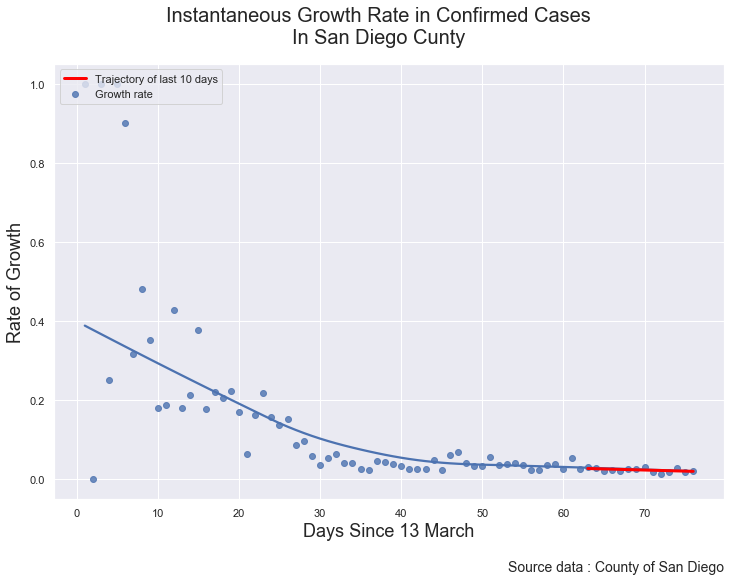

Coefficients: [[-0.00055009]] [0.06116241]
Zero growth at 111.18625248510348 days


In [16]:


def plot_gr(df, col):

    x = df.day.values.reshape(len(df), 1)[-14:]
    y = df[col].values.reshape(len(df), 1)[-14:]

    regr = linear_model.LinearRegression()
    regr.fit(x, y)

    fig, ax = plt.subplots(figsize=(12,8))
    fig.suptitle('Instantaneous Growth Rate in Confirmed Cases\nIn San Diego Cunty',fontsize=20)

    sns.regplot(ax=ax, x='day',y=col, data=df, lowess=True, label = 'Growth rate')

    ax.plot(x, regr.predict(x), color='red', linewidth=3, label = 'Trajectory of last 10 days')

    ax.set_xlabel('Days Since 13 March', fontsize=18)
    ax.set_ylabel('Rate of Growth', fontsize=18)

   
    plt.gcf().text(.65,0, f"Source data : County of San Diego", fontsize=14) 
    ax.legend(loc='upper left');
    plt.show()

    print('Coefficients:', regr.coef_, regr.intercept_)

    m = regr.coef_[0][0]
    b = regr.intercept_[0]

    
    
    print(f"Zero growth at {-b/m} days")

plot_gr(df.dropna(subset=['cases_rate']), 'cases_rate')
    

In [17]:
pkg = mp.open_package('http://library.metatab.org/covidtracking.com-covid19.csv')
states = pkg.resource('states').read_csv(parse_dates=True)
ca = states[states.state == 'CA'].copy()
ca['date'] = pd.to_datetime(ca.date, format="%Y%m%d")
ca['day'] = (ca.date - ca.date.min()).dt.days


In [18]:
pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations.csv')
ihme = pkg.resource('hospitalizations').read_csv(parse_dates=True)


/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


ValueError: `ydata` must not be empty!

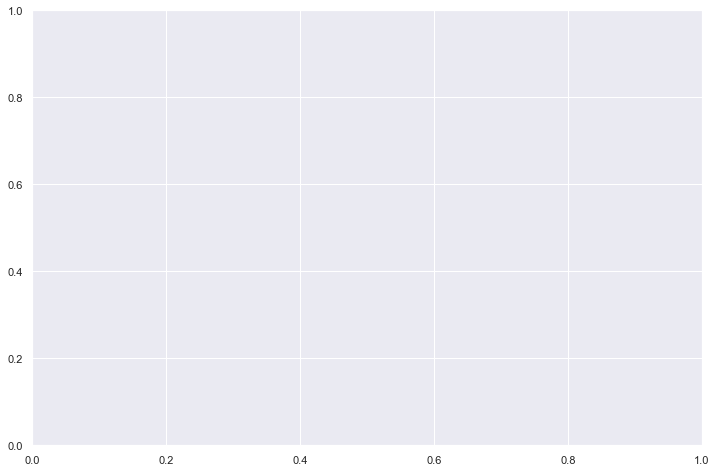

In [19]:
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

t = ihme[ihme.location_name == 'California'].copy()

fig, ax = plt.subplots(figsize=(12,8))

f = func_erf

popt, pcov = curve_fit(f, t.day, t.deaths_mean.cumsum(), p0=f.popt)

cat = ca.dropna(subset=['date','death'])

popt2, pcov = curve_fit(f, cat.day, cat.death, p0=popt)

ax.plot(t.day, t.deaths_mean.cumsum(), label="IHME Death Projection") # Blue line, CA deaths estimate from IHME
sns.scatterplot(ca.day, ca.death, ax=ax, label="Historic CA Deaths") # Actual death points for CA
ax.plot(t.day, f(t.day, *popt), label="erf fit to IHME projections") # Orange curve fit to IHME estimate
ax.plot(t.day, f(t.day, *popt2), label="erf fit to actual deaths") # Curve fit to points

#ax.set_xlim(0,100)
#ax.set_xlim(0,50)
#ax.set_ylim(0,1000)

ax.legend(loc='upper left');

ax.set_xlabel('Days Past 13 March 2020', fontsize=14)
ax.set_ylabel('Cumulative Deaths', fontsize=14)

fig.suptitle("California COVID-19 Deaths and IHME Projections", fontsize=20);

In [ ]:
pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.1.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

ihme1 = ihme[ihme.location_name == 'California'].copy()

pkg = mp.open_package('http://library.metatab.org/healthdata.org-hospitalizations-1.1.0.csv')
ihme = pkg.resource('hospitalizations').dataframe()
ihme['date'] = pd.to_datetime(ihme.date)
ihme['day'] = (ihme.date - ca.date.min()).dt.days

ihme2 = ihme[ihme.location_name == 'California'].copy()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(ihme1.date, ihme1.deaths_mean, label="IHME Deaths, 1 April")
ax.plot(ihme2.date, ihme2.deaths_mean, label="IHME Deaths, 15 April")
fig.suptitle("IHME Death Projections For California\n1 April 2020 and 14 April 2020", fontsize=20);
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Deaths Per Day', fontsize=14)
ax.legend(loc='upper left');

In [ ]:
sns.regplot(ca.day, np.log(ca.positive))

x = ca.day.values.reshape(len(ca), 1)
y = np.log(ca.positive).values.reshape(len(ca), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Coefficients:', regr.coef_, regr.intercept_)
print("Correlation:", ca.day.corr(np.log(ca.positive)))

m = regr.coef_[0][0]
b = regr.intercept_[0]
